### Step 1: Interpolation

The average diameter is 108.46 pixels or 17.35 microns


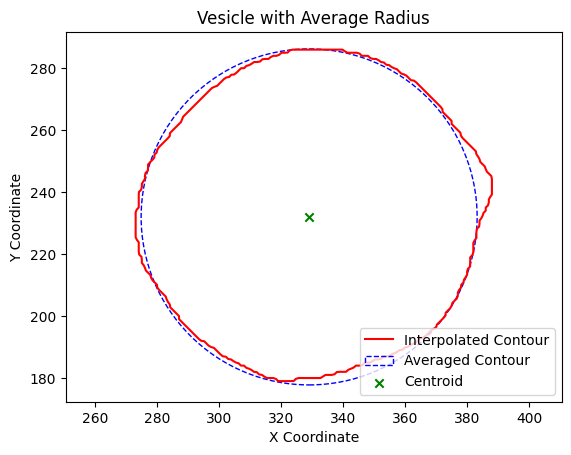

In [39]:
import json
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

with open('Caski17_log.json', 'r') as file:
    data = json.load(file)
    
def interpolate_coordinates(coords, num_points=360):
    coords_array = np.array(coords + [coords[0]])  # Append first point to end to close the loop
    distances = np.sqrt(np.sum(np.diff(coords_array, axis=0)**2, axis=1))
    cumulative_distances = np.insert(np.cumsum(distances), 0, 0)
    interpolated_distances = np.linspace(0, cumulative_distances[-1], num_points)
    interp_func_x = interp1d(cumulative_distances, coords_array[:,0], kind='linear')
    interp_func_y = interp1d(cumulative_distances, coords_array[:,1], kind='linear')
    interpolated_x = interp_func_x(interpolated_distances)
    interpolated_y = interp_func_y(interpolated_distances)
    return np.column_stack((interpolated_x, interpolated_y))

def calculate_radius(centroid, coords):
    return [euclidean(centroid, point) for point in coords]

all_radii = []
for frame in data:
    interpolated_coords = interpolate_coordinates(frame['circumference_coordinates'])
    centroid = frame['centroid']
    radii = calculate_radius(centroid, interpolated_coords)
    all_radii.append(np.mean(radii))
global_average_radius = np.mean(all_radii)

print('The average diameter is '
      + '{0:.2f}'.format(global_average_radius*2) 
      + ' pixels or ' 
      + '{0:.2f}'.format(global_average_radius*2*0.16) + ' microns')

first_frame = data[0]
centroid = first_frame['centroid']
interpolated_coords = interpolate_coordinates(first_frame['circumference_coordinates'])
plt.figure()
plt.plot(interpolated_coords[:, 0], interpolated_coords[:, 1], 'r-', label='Interpolated Contour')
circle = plt.Circle((centroid[0], centroid[1]), global_average_radius, color='b', fill=False, linestyle='--', label='Averaged Contour')
plt.gca().add_patch(circle)
plt.scatter(centroid[0], centroid[1], color='g', marker='x', label='Centroid')
plt.title('Vesicle with Average Radius')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend( loc='lower right', bbox_to_anchor=(1, 0), facecolor='white')
plt.axis('equal')
plt.show()


### Step 2: Polar Coordinates

In [44]:
def convert_to_polar(centroid, coords):
    x_offset = coords[:, 0] - centroid[0]
    y_offset = coords[:, 1] - centroid[1]
    radius = np.sqrt(x_offset**2 + y_offset**2)
    angle = np.arctan2(y_offset, x_offset)
    return radius, angle

all_polar_coords = {}
for frame in data:
    radius, angle = convert_to_polar(centroid, interpolated_coords)
    all_polar_coords[frame['frame_number']] = {'radius': radius, 'angle': angle}

for frame_number in list(all_polar_coords.keys())[:2]:  # Print details for the first 5 frames
    frame_data = all_polar_coords[frame_number]
    print(f"Frame {frame_number}:")
    print("Number of angles: ", len(frame_data['angle']))
    print("Number of radii: ", len(frame_data['radius']))
    print("Sample angles: ", frame_data['angle'][:5])
    print("Sample radii: ", frame_data['radius'][:5]) 
    print()
    


Frame 1:
Number of angles:  360
Number of radii:  360
Sample angles:  [-1.75728323 -1.77286222 -1.79026458 -1.80862891 -1.82683119]
Sample radii:  [53.93514624 53.37410441 53.27795954 53.50615033 53.75222925]

Frame 2:
Number of angles:  360
Number of radii:  360
Sample angles:  [-1.75728323 -1.77286222 -1.79026458 -1.80862891 -1.82683119]
Sample radii:  [53.93514624 53.37410441 53.27795954 53.50615033 53.75222925]


### Step 3: Equatorial Contour Correlation Function 